In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
recipes = pd.read_excel('Unsupervised_Capstone.xlsx')

In [3]:
recipes.head()

,Title,Author,Time,Summary,Steps,Reviews,Calories,Fat,Carbs,Protein
0,Summer Squash Fritters With Garlic Dipping Sauce,KIM SEVERSON,85,"David Venable, the most popular host on QVC, h...",PREPARE THE DIPPING SAUCE: Heat oven to 375 de...,155,253.0,22.0,9.0,3.0
1,Creamy Ramp Pesto Pasta,KIM SEVERSON,30,Ramps are one of those items that seem so appe...,Bring a large pot of water to a boil for pasta...,47,516.0,21.0,62.0,18.0
2,Mushroom Risotto With Peas,MARTHA ROSE SHULMAN,50,If you are ever at a loss for what to make for...,Bring stock or broth to a simmer in a saucepan...,709,NaN,NaN,NaN,NaN
3,Mussel Risotto,MARTHA ROSE SHULMAN,45,I usually keep a good supply of arborio rice o...,Clean the mussels. Inspect each one carefully ...,23,603.0,9.0,93.0,27.0
4,Asparagus Frittata With Burrata and Herb Pesto,DAVID TANIS,30,"Frittata, the savory Italian egg dish, can be ...","Rinse asparagus, and pat dry. Cut into 1-inch ...",275,373.0,33.0,3.0,15.0


In [4]:
#Add in recipe number
recipes = recipes.reset_index()
recipes.columns = ['Recipe_Num','Title', 'Author', 'Time', 'Summary', 'Steps', 'Reviews',\
'Calories', 'Fat', 'Carbs', 'Protein']
recipes['Text'] = (recipes.Summary + recipes.Steps)

In [137]:
display(recipes.head())

,Recipe_Num,Title,Author,Time,Summary,Steps,Reviews,Calories,Fat,Carbs,Protein,Text
0,0,Summer Squash Fritters With Garlic Dipping Sauce,KIM SEVERSON,85,"David Venable, the most popular host on QVC, h...",PREPARE THE DIPPING SAUCE: Heat oven to 375 de...,155,253.0,22.0,9.0,3.0,"David Venable, the most popular host on QVC, h..."
1,1,Creamy Ramp Pesto Pasta,KIM SEVERSON,30,Ramps are one of those items that seem so appe...,Bring a large pot of water to a boil for pasta...,47,516.0,21.0,62.0,18.0,Ramps are one of those items that seem so appe...
2,2,Mushroom Risotto With Peas,MARTHA ROSE SHULMAN,50,If you are ever at a loss for what to make for...,Bring stock or broth to a simmer in a saucepan...,709,NaN,NaN,NaN,NaN,If you are ever at a loss for what to make for...
3,3,Mussel Risotto,MARTHA ROSE SHULMAN,45,I usually keep a good supply of arborio rice o...,Clean the mussels. Inspect each one carefully ...,23,603.0,9.0,93.0,27.0,I usually keep a good supply of arborio rice o...
4,4,Asparagus Frittata With Burrata and Herb Pesto,DAVID TANIS,30,"Frittata, the savory Italian egg dish, can be ...","Rinse asparagus, and pat dry. Cut into 1-inch ...",275,373.0,33.0,3.0,15.0,"Frittata, the savory Italian egg dish, can be ..."


In [6]:
recipes_noNan = recipes.iloc[:,:6]

In [109]:
recipes_nutr = recipes.dropna()

In [7]:
#Separate out purely numerical data for train and test sets
NumX_train, NumX_test, Numy_train, Numy_test, recipes_train, recipes_test =\
    train_test_split(
    recipes.iloc[:,[3,6]],
    recipes.iloc[:,[2]], recipes,
    test_size=0.2,
    random_state=42)

In [133]:
#Clustering based on the two numerical categories
recipes_num = recipes.iloc[:,[3,6]]

#Normalize Data
ss = StandardScaler()
recipes_num_normal = ss.fit_transform(NumX_train)

In [307]:
#MeanShift Clustering
bandwidth = estimate_bandwidth(recipes_num_normal, quantile=0.2, n_samples=120)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_pred = ms.fit_predict(recipes_num_normal)
labels = ms.labels_
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 7


In [308]:
recipes_train['Meanshift'] = ms_pred

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


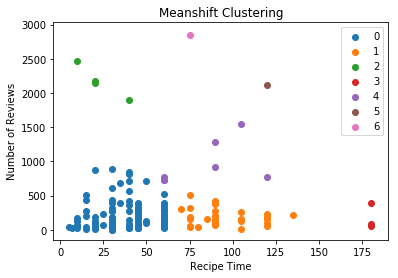

In [309]:
for num in range(7):
    plt.scatter(NumX_train.iloc[(ms_pred==num),0],NumX_train.iloc[(ms_pred==num),1], label=num)
plt.legend()
plt.title('Meanshift Clustering')
plt.xlabel('Recipe Time')
plt.ylabel('Number of Reviews')
plt.show()

In [163]:
print('--------------------','\n','Time v Reviews','\n')
for num in range(7):
    print(num, recipes_train.loc[(ms_pred == num), 'Author'].value_counts().head(5), '\n')
    print(recipes_train.loc[(ms_pred == num), ['Time', 'Reviews',]].mean(), '\n')
    print('Percentage of Reviews by Time {0:.2f}'.format((recipes_train.loc[(ms_pred == num), ['Time']].mean())[0]/
                                                   recipes_train.loc[(ms_pred == num), ['Reviews']].mean()[0]))

-------------------- 
 Time v Reviews 

0 DAVID TANIS             16
SAM SIFTON              15
FLORENCE FABRICANT      14
SAMANTHA SENEVIRATNE    12
MARK BITTMAN            11
Name: Author, dtype: int64 

Time        37.935185
Reviews    203.268519
dtype: float64 

Percentage of Reviews by Time 0.19
1 SAMANTHA SENEVIRATNE    6
JULIA MOSKIN            4
MELISSA CLARK           4
MARTHA ROSE SHULMAN     4
DAVID TANIS             3
Name: Author, dtype: int64 

Time        94.333333
Reviews    177.066667
dtype: float64 

Percentage of Reviews by Time 0.53
2 MARIAN BURROS    2
MARK BITTMAN     1
JULIA MOSKIN     1
Name: Author, dtype: int64 

Time         22.5
Reviews    2170.0
dtype: float64 

Percentage of Reviews by Time 0.01
3 DAVID TANIS      1
JULIA MOSKIN     1
MARIAN BURROS    1
Name: Author, dtype: int64 

Time       180.000000
Reviews    175.333333
dtype: float64 

Percentage of Reviews by Time 1.03
4 MARIAN BURROS          2
MARTHA ROSE SHULMAN    2
JULIA MOSKIN           1
KIM 

In [167]:
#Try KMeans Cluster
km = KMeans(n_clusters=7)
y_pred = km.fit_predict(recipes_num_normal)
recipes_train['KMeans'] = y_pred

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [169]:
print('--------------------','\n','Time v Reviews','\n')
for num in range(7):
    print(num, recipes_train.loc[(y_pred == num), 'Author'].value_counts().head(5), '\n')
    print(recipes_train.loc[(y_pred == num), ['Time', 'Reviews',]].mean(), '\n')
    print('Percentage of Reviews by Time {0:.2f}'.format((recipes_train.loc[(y_pred == num), ['Time']].mean())[0]/
                                                   recipes_train.loc[(y_pred == num), ['Reviews']].mean()[0]))
    

-------------------- 
 Time v Reviews 

0 JULIA MOSKIN           3
SAM SIFTON             3
MARK BITTMAN           3
MARTHA ROSE SHULMAN    3
DAVID TANIS            2
Name: Author, dtype: int64 

Time        40.238095
Reviews    605.857143
dtype: float64 

Percentage of Reviews by Time 0.07
1 MARIAN BURROS          2
JULIA MOSKIN           1
KIM SEVERSON           1
MARTHA ROSE SHULMAN    1
Name: Author, dtype: int64 

Time        105.0
Reviews    1329.0
dtype: float64 

Percentage of Reviews by Time 0.08
2 SAMANTHA SENEVIRATNE    5
JULIA MOSKIN            4
MELISSA CLARK           4
MARTHA ROSE SHULMAN     4
DAVID TANIS             3
Name: Author, dtype: int64 

Time        95.172414
Reviews    172.896552
dtype: float64 

Percentage of Reviews by Time 0.55
3 MARIAN BURROS    3
MARK BITTMAN     1
JULIA MOSKIN     1
Name: Author, dtype: int64 

Time         33.0
Reviews    2306.2
dtype: float64 

Percentage of Reviews by Time 0.01
4 DAVID TANIS      1
JULIA MOSKIN     1
MARIAN BURROS   

In [269]:
sc = SpectralClustering(n_clusters=5)
sc_pred = sc.fit_predict(recipes_num_normal)
recipes_train['Spectral'] = sc_pred

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [200]:
print('--------------------','\n','Time v Reviews','\n')
for num in range(5):
    print(num, recipes_train.loc[(sc_pred == num), 'Author'].value_counts().head(5), '\n')
    print(recipes_train.loc[(sc_pred == num), ['Time', 'Reviews',]].mean(), '\n')
    print('Percentage of Reviews by Time {0:.2f}'.format((recipes_train.loc[(sc_pred == num), ['Time']].mean())[0]/
                                                   recipes_train.loc[(sc_pred == num), ['Reviews']].mean()[0]),'\n')
    

-------------------- 
 Time v Reviews 

0 FLORENCE FABRICANT      12
DAVID TANIS             12
MELISSA CLARK            8
SAM SIFTON               8
SAMANTHA SENEVIRATNE     8
Name: Author, dtype: int64 

Time        30.693333
Reviews    158.320000
dtype: float64 

Percentage of Reviews by Time 0.19 

1 SAMANTHA SENEVIRATNE    5
MELISSA CLARK           4
MARTHA ROSE SHULMAN     4
DAVID TANIS             3
JULIA MOSKIN            3
Name: Author, dtype: int64 

Time        95.892857
Reviews    161.107143
dtype: float64 

Percentage of Reviews by Time 0.60 

2 SAM SIFTON              6
MARK BITTMAN            5
SAMANTHA SENEVIRATNE    5
DAVID TANIS             4
JULIA MOSKIN            3
Name: Author, dtype: int64 

Time        60.178571
Reviews    191.142857
dtype: float64 

Percentage of Reviews by Time 0.31 

3 DAVID TANIS      1
JULIA MOSKIN     1
MARIAN BURROS    1
Name: Author, dtype: int64 

Time       180.000000
Reviews    175.333333
dtype: float64 

Percentage of Reviews by Time

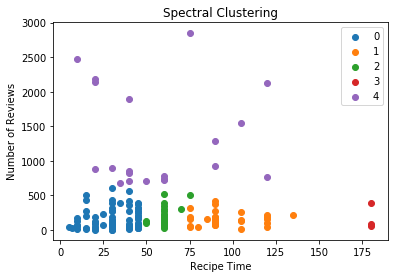

In [201]:
for num in range(5):
    plt.scatter(NumX_train.iloc[(sc_pred==num),0],NumX_train.iloc[(sc_pred==num),1], label=num)
plt.legend()
plt.title('Spectral Clustering')
plt.xlabel('Recipe Time')
plt.ylabel('Number of Reviews')
plt.show()

In [199]:
for num in [2,3,4]:
    print(num, recipes.iloc[(sc_pred==num),1].head(5), '\n')

2 4     Asparagus Frittata With Burrata and Herb Pesto
8                                       Pumpkin Flan
13                                  Potato Cavatelli
15       Seared Scallops With Hot Sauce Beurre Blanc
32                  Lemon Risotto with Summer Squash
Name: Title, dtype: object 

3 30           Roasted Portobellos With Pesto
59                  Sticky Bun Monkey Bread
60    Giant Crinkled Chocolate Chip Cookies
Name: Title, dtype: object 

4 6             Lemon Meringue Tart
17          Avocado-Cucumber Soup
18             Green Tomato Salad
23    Green Chilaquiles With Eggs
29              Peach 'Doughnuts'
Name: Title, dtype: object 



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


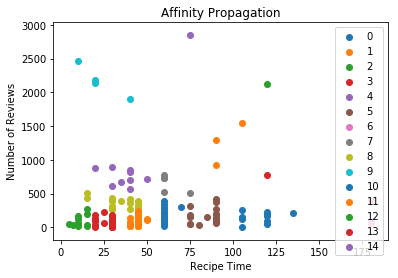

In [184]:
af = AffinityPropagation()
af_pred = af.fit_predict(recipes_num_normal)
recipes_train['Affinity'] = af_pred

for num in range(len(af.cluster_centers_indices_)):
    plt.scatter(NumX_train.iloc[(af_pred==num),0],NumX_train.iloc[(af_pred==num),1], label=num)
plt.legend()
plt.title('Affinity Propagation')
plt.xlabel('Recipe Time')
plt.ylabel('Number of Reviews')
plt.show()

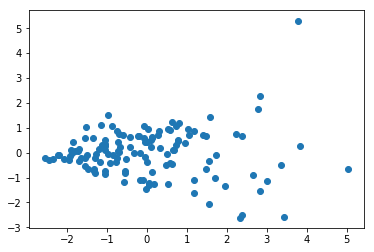

In [121]:
#Clustering on subset of data without Null values including nutriontional info
Nutr_num = recipes_nutr.iloc[:,7:-1]
ss_num = StandardScaler()
Nutr_norm = ss_num.fit_transform(Nutr_num)

pca_nut = PCA(n_components=2)
pca_nutrition = pca_nut.fit_transform(Nutr_norm)

plt.scatter(pca_nutrition[:,0],pca_nutrition[:,1], )

In [260]:
sc_nutr = SpectralClustering(n_clusters=5)
sc_nutr_pred = sc_nutr.fit_predict(pca_nutrition)
recipes_nutr['Spectral_Nutritional'] = sc_nutr_pred

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


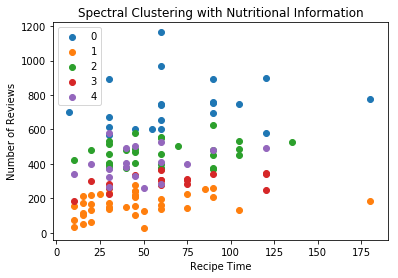

In [261]:
for num in range(5):
    plt.scatter(recipes_nutr.iloc[(sc_nutr_pred==num),3],recipes_nutr.iloc[(sc_nutr_pred==num),7], label=num)
plt.legend()
plt.title('Spectral Clustering with Nutritional Information')
plt.xlabel('Recipe Time')
plt.ylabel('Number of Reviews')
plt.show()

In [264]:
print('--------------------','\n','Breakdown of Clusters','\n')
for num in range(5):
    print(num,'\n', len(recipes_nutr.loc[(sc_nutr_pred == num),:]),'\n')
    print(recipes_nutr.loc[(sc_nutr_pred == num), ['Carbs','Fat','Protein']].mean(), '\n')


-------------------- 
 Breakdown of Clusters 

0 
 21 

Carbs      67.476190
Fat        40.761905
Protein    25.619048
dtype: float64 

1 
 40 

Carbs      16.275
Fat         8.750
Protein     5.825
dtype: float64 

2 
 31 

Carbs      62.516129
Fat        17.741935
Protein    12.258065
dtype: float64 

3 
 17 

Carbs      44.117647
Fat        10.764706
Protein     5.058824
dtype: float64 

4 
 18 

Carbs      18.611111
Fat        28.666667
Protein    15.444444
dtype: float64 



In [304]:
#Run on testing set to identifying similar groupings
ss_test = StandardScaler()
recipes_num_ntest = ss_test.fit_transform(NumX_test)

ms_test_pred = ms.predict(recipes_num_ntest)
recipes_test['Meanshift_Test'] = ms_test_pred

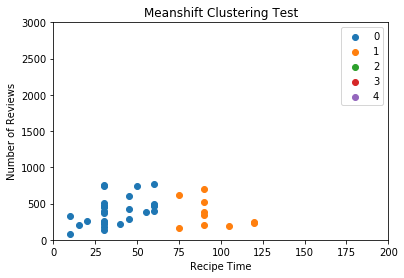

In [313]:
for num in range(5):
    plt.scatter(recipes_test.iloc[(ms_test_pred==num),3],recipes_nutr.iloc[(ms_test_pred==num),7], label=num)
plt.legend()
plt.title('Meanshift Clustering Test')
plt.xlabel('Recipe Time')
plt.xlim([0, 200])
plt.ylabel('Number of Reviews')
plt.ylim([0,3000])
plt.show()

# Breaking Down Text Data
## Bag of Words Feature Generation

In [317]:
#Function to process data
nlp = spacy.load('en')

def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(20)]

def process_text(df_line):
    #Break dataframe line into useable segments
    recipe_number = df_line[0]
    recipe_title = df_line[1]
    recipe_author = df_line[2]
    recipe_time = df_line[3]
    recipe_summary = df_line[4]
    recipe_instr = df_line[5]
    recipe_reviews = df_line[6]
    recipe_cal = df_line[7]
    recipe_fat = df_line[8]
    recipe_carb = df_line[9]
    recipe_protein = df_line[10]
    recipe_text = df_line[11]
    
    #Process summary into sentences
    summary_doc = nlp(recipe_summary)
    summary_sent = [[recipe_number, recipe_author, recipe_time, sent, recipe_reviews,
                    recipe_cal, recipe_fat,recipe_carb, recipe_protein] 
                    for sent in summary_doc.sents]
    
    #Process full text into sentences
    text_doc = nlp(recipe_text)
    text_sent = [[recipe_number, recipe_author, recipe_time, recipe_reviews,
                    recipe_cal, recipe_fat,recipe_carb, recipe_protein, sent] 
                    for sent in text_doc.sents]
    
    
    #Create new dataframe with those sentences
    df = pd.DataFrame(summary_sent)
    df1 = pd.DataFrame(text_sent)
    #Add column names back
    df.columns = ['Recipe_Num','Author','Time','Sent','Reviews','Calories','Fat',
                 'Carbs','Protein']
    df1.columns = ['Recipe_Num','Author','Time','Reviews','Calories','Fat',
                 'Carbs','Protein','Text']
    return df, df1

In [318]:
#Create complete dataframe with all the sentences
df_exist = pd.DataFrame()

for ind in range(len(recipes)):
    line = recipes.iloc[ind,:]
    df_new_s, df_new_t = process_text(line)
    df_exist = pd.concat([df_new_t, df_exist])

recipes_sents = df_exist.reset_index().drop(columns=['index'])

In [320]:
recipes_sents = recipes_sents.drop(columns=['Calories','Fat','Carbs','Protein'])

In [323]:
recipes_sents.head()

,Recipe_Num,Author,Time,Reviews,Text
0,192,MARIAN BURROS,90,142,"(Some, cheesecakes, are, the, culinary, equiva..."
1,192,MARIAN BURROS,90,142,"(This, one, ,, first, published, in, The, Time..."
2,192,MARIAN BURROS,90,142,"(It, 's, lightly, -, sweet, ,, slightly, tangy..."
3,192,MARIAN BURROS,90,142,"(The, texture, is, surprisingly, airy, .)"
4,192,MARIAN BURROS,90,142,"(Serve, slices, with, a, dollop, of, whipped, ..."


In [324]:
def bow_df(df, df_sents):
    common_words = []
    for ind in range(len(df)):
        text = df.Summary[ind]
        text_doc = nlp(text)
        bow_add = bag_of_words(text_doc)
        common_words = list(set(common_words+bow_add))
    
    #Initialize df and set word counts to zero
    count_df = pd.DataFrame(columns=common_words)
    count_df['Recipe_Num'] = df_sents.iloc[:,0]
    count_df['Author'] = df_sents.iloc[:,1]
    count_df['Time'] = df_sents.iloc[:,2]
    count_df['Reviews'] = df_sents.iloc[:,3]
    count_df['Sents'] = df_sents.iloc[:,4]
    count_df.loc[:, common_words] = 0
    
    #Process each word and the occurance of each word in each row
    for i, sentence in enumerate(count_df['Sents']):
        
        #Find common words while filtering out stop words and punctuation
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        for word in words:
            count_df.loc[i, word] += 1
            
        #Keep counter to make sure it doesn't hang
        if i % 200 == 0:
            print("Processing row {}".format(i))
    
    return count_df

In [325]:
recipes_bow = bow_df(recipes, recipes_sents)

Processing row 0
Processing row 200
Processing row 400
Processing row 600
Processing row 800
Processing row 1000
Processing row 1200
Processing row 1400
Processing row 1600
Processing row 1800
Processing row 2000
Processing row 2200
Processing row 2400
Processing row 2600
Processing row 2800
Processing row 3000
Processing row 3200
Processing row 3400
Processing row 3600
Processing row 3800


In [327]:
#Testing Bag of Words
X = recipes_bow.drop(columns=['Author','Sents','Recipe_Num'])
Y = recipes_bow.Author
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=1334)

In [329]:
#Testing Bag of Words
X_time = recipes_bow.drop(columns=['Author','Sents','Recipe_Num','Time'])
Y_time = recipes_bow.Time
X_train_time, X_test_time, y_train_time, y_test_time = train_test_split(X_time,
                                            Y_time, test_size=0.3, random_state=1334)

In [330]:
#Testing with Random Forest Classifier
rfc = ensemble.RandomForestClassifier(n_estimators=50)
rfc.fit(X_train,y_train)
rfc_bow = cross_val_score(rfc, X_train, y_train, cv=3)
print(rfc_bow.mean())

0.5415427880037262


In [334]:
#Testing with Logistic Regression
lr = LogisticRegression(C=1)
lr.fit(X_train, y_train)
lr_bow = cross_val_score(lr, X_train, y_train, cv=3)
print(lr_bow.mean())

0.3711052207617957


## Tf-idf Feature Generation

In [341]:
#Unsupervised Feature Tf-idf generator
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
sents_tfidf = vectorizer.fit_transform(recipes_sents.Text.map(str))



In [342]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    sents_tfidf, recipes_sents.Author, test_size=0.3,random_state=1334)

In [347]:
#Testing with Random Forest Classifier
rfc2 = ensemble.RandomForestClassifier(n_estimators=200)
rfc2.fit(X_train_tfidf,y_train_tfidf)
rfc_tfidf = cross_val_score(rfc2, X_train_tfidf, y_train_tfidf, cv=3)
print(rfc_tfidf.mean())

0.3353915467875708


In [423]:
#Testing with Logistic Regression
lr2 = LogisticRegression(C=1)
lr2.fit(X_train_tfidf, y_train_tfidf)
lr_tfidf = cross_val_score(lr2, X_train_tfidf, y_train_tfidf, cv=3)
print(lr_tfidf.mean())

0.3389869645617385


In [400]:
#PCA to reduce components
pca = PCA(n_components=2)
sents_pca = pca.fit_transform(sents_tfidf.todense())
    
#Cluster reduced data
bandwidth_2 = estimate_bandwidth(sents_pca)
ms_2 = MeanShift(bandwidth=bandwidth_2, bin_seeding=True)
ms_2.fit(sents_pca)
labels_2 = ms_2.labels_
n_clusters_2 = len(np.unique(labels_2))

print("Number of estimated clusters: {}".format(n_clusters_2))

Number of estimated clusters: 5


In [404]:
recipes_sents['Meanshift'] = labels_2

In [362]:
pd.crosstab(ms_2.predict(sents_pca), recipes_sents.Author)

Author,DAVID TANIS,FLORENCE FABRICANT,JULIA MOSKIN,KIM SEVERSON,MARIAN BURROS,MARK BITTMAN,MARTHA ROSE SHULMAN,MELISSA CLARK,SAM SIFTON,SAMANTHA SENEVIRATNE
row_0,,,,,,,,,,
0,422,317,457,325,211,224,393,370,352,432
1,14,21,23,13,10,9,30,11,14,11
2,3,3,4,4,3,2,1,2,0,11
3,13,7,2,1,1,2,10,0,5,2
4,26,11,27,18,5,29,33,24,26,24


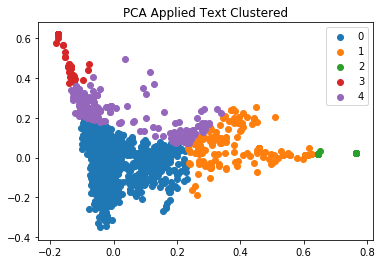

In [397]:
for num in range(5):
    plt.scatter(sents_pca[(labels_2==num),0],sents_pca[(labels_2==num),1], label=num)
plt.title('PCA Applied Text Clustered')
plt.legend()
plt.show()

In [415]:
recipes_sents.loc[(recipes_sents.Meanshift == 4),['Text']]

,Text
26,"(Heat, oil, in, a, heavy, pan, large, enough, ..."
35,"(Season, with, salt, ,, if, desired, .)"
56,"(When, mixture, thickens, a, little, ,, remove..."
87,"(In, medium, bowl, ,, combine, 1, 1/2, cups, f..."
221,"(Add, the, flour, ,, baking, powder, ,, salt, ..."
328,"(Meanwhile, ,, heat, 3, tablespoons, oil, on, ..."
338,"(When, arugula, has, just, wilted, ,, season, ..."
346,"(Whisk, in, oil, ,, fold, in, capers, and, sea..."
360,"(Whisk, flour, with, 1/2, teaspoon, salt, .)"
372,"(Season, with, a, pinch, of, salt, and, pepper..."


# Additional Modeling

In [418]:
rfc_bow_test = cross_val_score(rfc, X_test, y_test, cv=3)
print('Testing Bag of Words {}'.format(rfc_bow_test.mean()))

lr_tfidf_test = cross_val_score(lr2, X_test_tfidf, y_test_tfidf, cv=3)
print('Testing Tf-idf {}'.format(lr_tfidf_test.mean()))

Testing Bag of Words 0.4417079825030439
Testing Tf-idf 0.2709061138418789


In [426]:
df_graph = pd.DataFrame()
df_graph['BoW Train'] = rfc_bow
df_graph['BoW Test'] = rfc_bow_test
df_graph['Tfidf Train'] = lr_tfidf
df_graph['Tfidf Test'] = lr_tfidf_test

,BoW Train,BoW Test,Tfidf Train,Tfidf Test
0,0.530238,0.445000,0.344492,0.290000
1,0.533044,0.478589,0.328277,0.269521
2,0.561346,0.401535,0.344191,0.253197


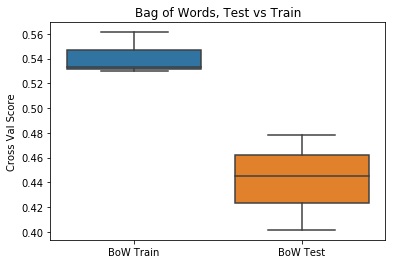

In [431]:
sns.boxplot(data=df_graph.iloc[:,[0,1]])
plt.title('Bag of Words, Test vs Train')
plt.ylabel('Cross Val Score')
plt.show()

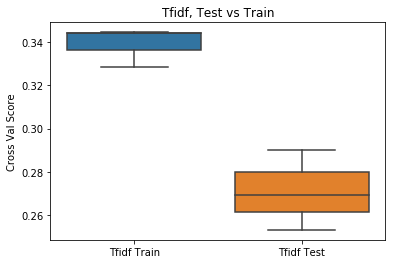

In [432]:
sns.boxplot(data=df_graph.iloc[:,[2,3]])
plt.title('Tfidf, Test vs Train')
plt.ylabel('Cross Val Score')
plt.show()

In [332]:
#Testing with Random Forest Regressor to predict time
rfc_time = ensemble.RandomForestRegressor(n_estimators=50)
rfc_time.fit(X_train_time,y_train_time)
rfc_bow_time = cross_val_score(rfc_time, X_train_time, y_train_time, cv=3)
print(rfc_bow_time.mean())

0.8274360413931342
